# 1. INTRODUCTION
Case study:
The ab_data.csv data contain the results of an A/B test run by an e-commerce website. We need to check that based on the data, whether the company should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

# 2. EXPLORATORY DATA ANALYSIS

## 2.1. OVERVIEW ABOUT THE DATA

In [1]:
### Import neccessary packages
import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt


Matplotlib is building the font cache; this may take a moment.


In [2]:
%matplotlib inline


In [9]:
data_df = pd.read_csv('ab_data.csv', header = 0)
print(data_df.shape)
data_df.head(5)

(294478, 5)


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
print(min(data_df.timestamp), max(data_df.timestamp))

2017-01-02 13:42:05.378582 2017-01-24 13:41:54.460509


In [11]:
data_df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


### Missing values - Unique - Duplicate

In [12]:
data_df.isnull().sum()
# => There is no missing value

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [13]:
### Number of unique user
data_df['user_id'].nunique()

290584

In [14]:
### Duplicate in user_id
data_df.user_id.value_counts()

805339    2
754884    2
722274    2
783176    2
898232    2
         ..
642985    1
771499    1
923606    1
712675    1
715931    1
Name: user_id, Length: 290584, dtype: int64

In [15]:
### Number of users that are duplicated 
sum(data_df.user_id.value_counts().values > 1)

3894

### Check Class Balance (number of observations in each treatment group)

In [16]:
### Ratio between treatment and control
data_df.group.value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

In [17]:
### Ratio of converted
data_df.converted.value_counts()

0    259241
1     35237
Name: converted, dtype: int64

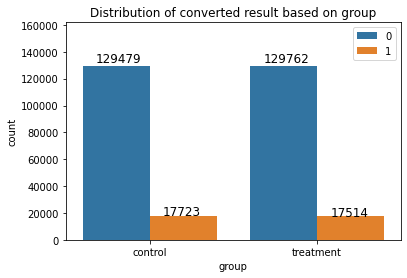

In [18]:
#### Plot the distribution
fig = sns.countplot(data = data_df, x = 'group', hue = 'converted')
### Adding label:
for p in fig.patches:
    if str(p.get_height()) != 'nan':
        fig.text(p.get_x() + 0.08,  
                 p.get_height() * 1.02, 
                 '{}'.format(p.get_height()),
                size = 'large')
plt.legend(loc = 'upper right')
plt.ylim([0, data_df.query('group == "control"').shape[0]*1.1])
plt.title('Distribution of converted result based on group')
plt.show()

## 2.2. SANITY CHECK

### 2.2.1. CLEAN UP DUPLICATE AND WRONG ASSIGNMENTS

PROBLEMS:
Control is the old page. Treatment is the new page. But there are some wrong assignments that should be removed.

The number of unique user is smaller than the rows => duplicated users => remove

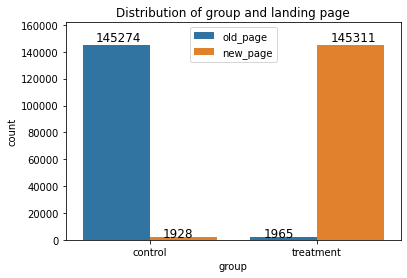

In [19]:
fig = sns.countplot(data = data_df, x = 'group', hue = 'landing_page')
### Adding label:
for p in fig.patches:
    if str(p.get_height()) != 'nan':
        fig.text(p.get_x() + 0.08,  
                 p.get_height() * 1.02, 
                 '{}'.format(p.get_height()),
                size = 'large')
        
plt.legend(loc = 'upper center')
plt.title('Distribution of group and landing page')
plt.ylim([0, data_df.query('group == "control"').shape[0]*1.1])

plt.show()

#### CLEAN UP THE DATA

In [20]:
### Remove the row where group and landing page don't match
df_clean = data_df.query('(group == "treatment" & landing_page != "old_page") | \
              (group == "control" & landing_page != "new_page") ')
df_clean.shape

(290585, 5)

In [21]:
#### The removal above help remove most of the redundant user. 
df_clean.user_id.nunique()

290584

In [22]:
### Find out about the redundant user
df_clean.user_id.value_counts()

773192    2
851104    1
688307    1
718297    1
838144    1
         ..
755610    1
804629    1
837875    1
889019    1
715931    1
Name: user_id, Length: 290584, dtype: int64

In [23]:
df_clean.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [24]:
### User_id the same, just different in timestamp => could use, remove 1 line
df_clean = df_clean.drop(2893)
# Verify the drop
df_clean.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


### 2.2.2. CHECKING INVARIANTS

OVERALL

Is the difference in the number of user within expectation?

Given: Each user_id is randomly assigned to the control or experiment group with probability of 0.5. Steps to check whether the observed fraction is within the confidence interval:

Step 1. Compute standard deviation of binomial with probability 0.5 of success:

SD = np.sqrt(0.5*(1-0.5)/(n_c + n_t))

Step 2. Multiply by Z-score to get margin of error

m = SD * 1.96 (Z-score at siginificant level of 0.05)

Step 3. Compute confidence interaval around 0.5: 0.5 +/- m

Step 4. Check whether the observed fraction is within the confidence interval

In [26]:
#### The number of users in the control group
n_c = df_clean.query('group == "control"').user_id.nunique()
#### The number of users in the treatment group
n_t = df_clean.query('group == "treatment"').user_id.nunique()
c_ratio = n_c/(n_c + n_t)
print("Control: {} , Treatment: {} , Control ratio: {:.2f}".format(n_c, n_t, c_ratio))

Control: 145274 , Treatment: 145310 , Control ratio: 0.50


In [29]:
### Step 1. Compute standard error binomial with probability 0.5 of success
# This is also called the standard deviation of the sampling distribution for the proportion:
SE = np.sqrt(0.5*(1-0.5)/(n_c + n_t))
print("Standard deviation: {:.4f}", SE)
### Step 2. Multiply by Z-score to get margin of error
m = SE * 1.96 #(Z-score at siginificant level of 0.05)
print("Margin of error: {:.4f}", m)
### Step 3. Compute confidence interval around 0.5: 0.5 +/- m
print("Confidence interval around 0.5: {:.4f} ~ {:.4f}".format(0.5 - m, 0.5 + m))
### Step 4. Check whether the observed fraction is within the confidence interval
if c_ratio >= (0.5 - m) and  c_ratio <= (0.5 + m):
    print("The observed fraction {:.4f} is within the confidence interval ({:.4f} ~ {:.4f})"\
          .format(c_ratio, 0.5 - m, 0.5 + m))
else:
    print("The observed fraction {:.4f} is NOT within the confidence interval ({:.4f} ~ {:.4f})"\
          .format(c_ratio, 0.5 - m, 0.5 + m))

Standard deviation: {:.4f} 0.0009275432205326099
Margin of error: {:.4f} 0.0018179847122439155
Confidence interval around 0.5: 0.4982 ~ 0.5018
The observed fraction 0.4999 is within the confidence interval (0.4982 ~ 0.5018)


#### DAY BY DAY INSIGHTS

In [30]:
print("Start day: ", min(data_df.timestamp))
print("End day: ", max(data_df.timestamp))


Start day:  2017-01-02 13:42:05.378582
End day:  2017-01-24 13:41:54.460509


In [31]:
df_clean['date'] = pd.to_datetime(df_clean['timestamp']).dt.date
df_clean = df_clean.sort_values(by ='date')
df_clean.head(5)

,user_id,timestamp,group,landing_page,converted,date
184831,929659,2017-01-02 14:41:58.848698,treatment,new_page,0,2017-01-02
148281,779581,2017-01-02 16:31:51.186604,control,old_page,0,2017-01-02
248721,740003,2017-01-02 17:11:05.168172,control,old_page,1,2017-01-02
248722,823601,2017-01-02 23:41:20.188398,treatment,new_page,0,2017-01-02
77133,845187,2017-01-02 18:13:49.064532,treatment,new_page,0,2017-01-02


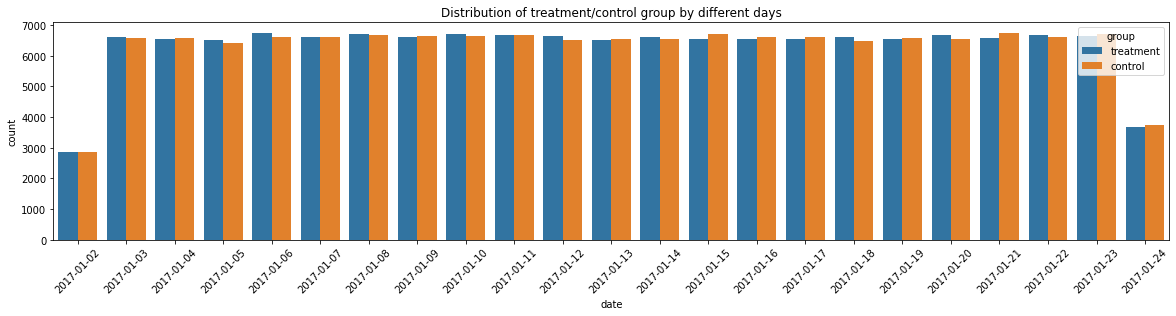

In [32]:
### Visualization
plt.figure(figsize = (20,4))
sns.countplot(data = df_clean, x = 'date', hue = 'group')
plt.xticks(rotation = 45)
plt.title('Distribution of treatment/control group by different days')
plt.show()

Only the first day and last day have half number of sample because the feature was launched only half day.

In [33]:
### The ratio of control/treatment in each day
# Group by date and group
ratio_df = df_clean.groupby(['date', 'group']).agg({'group': 'count'})
# Pivot into 2 columns
ratio_df = ratio_df.unstack('group')
# Drop the level
ratio_df = ratio_df.droplevel(0, axis = 1)
# Reset index so that date could be a column, not an index
ratio_df.reset_index(inplace = True)
# Remove the name of the index
ratio_df = ratio_df.rename_axis(None, axis=1)
### Add the control_ratio into the dataframe
ratio_df['control_ratio'] = ratio_df['control']/(ratio_df['control'] + ratio_df['treatment'])
ratio_df

,date,control,treatment,control_ratio
0,2017-01-02,2859,2853,0.500525
1,2017-01-03,6590,6618,0.498940
2,2017-01-04,6578,6541,0.501410
3,2017-01-05,6427,6505,0.496984
4,2017-01-06,6606,6747,0.494720
5,2017-01-07,6604,6609,0.499811
6,2017-01-08,6687,6700,0.499514
7,2017-01-09,6628,6615,0.500491
8,2017-01-10,6654,6696,0.498427
9,2017-01-11,6688,6673,0.500561


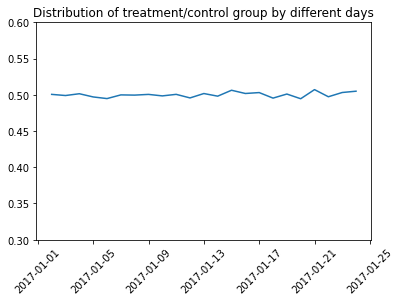

In [34]:
### Plot the ratio of control group across different days
plt.plot(ratio_df['date'], ratio_df['control_ratio'])
plt.ylim([0.3, 0.6])
plt.xticks(rotation = 45)
plt.title('Distribution of treatment/control group by different days')
plt.show()

# 3. PROBABILITY

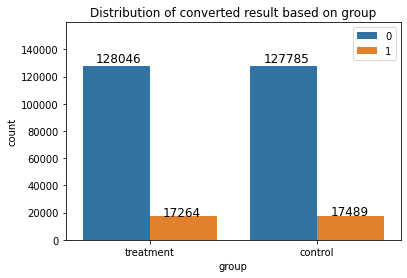

In [35]:
### Plot the distribution again on the clean dataframe
fig = sns.countplot(data = df_clean, x = 'group', hue = 'converted')
### Adding label:
for p in fig.patches:
    if str(p.get_height()) != 'nan':
        fig.text(p.get_x() + 0.08,  
                 p.get_height() * 1.02, 
                 '{}'.format(p.get_height()),
                size = 'large')
plt.legend(loc = 'upper right')
plt.ylim([0, df_clean.query('group == "control"').shape[0]*1.1])
plt.title('Distribution of converted result based on group')
plt.show()

## Converted ratio

In [36]:
### Overall converted_ratio
converted_ratio = df_clean.query('converted == 1').user_id.nunique()/df_clean.user_id.nunique()
converted_ratio

0.11959708724499628

In [40]:
# Converted_ratio on the control group
converted_ratio_control = df_clean.query('converted == 1 & group == "control"').user_id.nunique()/df_clean.query('group == "control"').user_id.nunique()
converted_ratio_control

0.1203863045004612

In [41]:
# Converted_ratio on the treament group
converted_ratio_treatment = df_clean.query('converted == 1 & group == "treatment"').user_id.nunique()/df_clean.query('group == "treatment"').user_id.nunique()
converted_ratio_treatment

0.11880806551510564

The probability that an individual received the new page

In [42]:
newpage_prob = df_clean.query('landing_page == "new_page"').user_id.nunique()\
                /df_clean.user_id.nunique()
newpage_prob

0.5000619442226688

To conclude:
Probability of converting regardless of page: 0.1196.

The probability users converted in

Control group (old page): 0.1204
Treatment group (new page): 0.1188
- These 2 numbers are quite equal. Regarding the fact that the proportion of users received the new page versus the old page are approximately the same (50%), there is unsufficient evidence to conclude that the new treatment page leads to more conversions.

=> We need hypothesis testing as evidence to conclude whether the new treatment page leads to more conversions or not

# 4. A/B TEST
Assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%.

## 4.1. A/B TEST - PROPORTION Z-TEST
One-tailed test

In [44]:
import statsmodels.api as sm

In [45]:
convert_c = df_clean.query('landing_page == "old_page" & converted == 1').shape[0]
convert_t = df_clean.query('landing_page == "new_page" & converted == 1').shape[0]
n_c = df_clean.query('landing_page == "old_page"').shape[0]
n_t = df_clean.query('landing_page == "new_page"').shape[0]
convert_c, convert_t, n_c, n_t

(17489, 17264, 145274, 145310)

In [46]:
count = np.array([convert_t, convert_c])
nobs = np.array([n_t, n_c])
stat, pval = sm.stats.proportions_ztest(count, nobs, alternative = "larger")
stat, pval 

(-1.3109241984234394, 0.9050583127590245)

The z-score = -1.311 and p-value = 0.905
=> No evidence to reject the null hypothesis

## 4.2. A/B TEST - LOGISTIC REGRESSION

### STEP 1: Create the intercept and the dummy variable

In [47]:
### Assign the intercept = 1
df2 = df_clean.copy()
df2['intercept'] = 1

In [48]:
### Create an dummpy variable ab_page: 0 for control, 1 for treatment
df2['ab_page'] = df2.group.apply(lambda x: 1 if x == 'treatment' else 0)
df2

,user_id,timestamp,group,landing_page,converted,date,intercept,ab_page
184831,929659,2017-01-02 14:41:58.848698,treatment,new_page,0,2017-01-02,1,1
148281,779581,2017-01-02 16:31:51.186604,control,old_page,0,2017-01-02,1,0
248721,740003,2017-01-02 17:11:05.168172,control,old_page,1,2017-01-02,1,0
248722,823601,2017-01-02 23:41:20.188398,treatment,new_page,0,2017-01-02,1,1
77133,845187,2017-01-02 18:13:49.064532,treatment,new_page,0,2017-01-02,1,1
...,...,...,...,...,...,...,...,...
163981,873720,2017-01-24 04:48:42.491365,treatment,new_page,0,2017-01-24,1,1
13297,815616,2017-01-24 01:03:27.408263,treatment,new_page,1,2017-01-24,1,1
197151,683700,2017-01-24 03:44:04.596907,treatment,new_page,0,2017-01-24,1,1
110810,868284,2017-01-24 07:08:53.359276,treatment,new_page,0,2017-01-24,1,1


### STEP 2: Use statsmodels to instantiate the regression model on the two columns you created in STEP1, then fit the model to predict whether or not an individual converts.

In [49]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# fit the regression model 
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


### STEP 3: Interpret the result

In [50]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 18 Apr 2022   Pseudo R-squ.:               8.077e-06
Time:                        10:45:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

Null hypothesis of the logistic regression: There is no relationship between the X variable - the page an user receives and the Y variable (the conversion rates).

The alternative hypothesis: the page an user receives affects the conversion rates.

In [51]:
### Interpret Results:
ab_page_coef = -0.0150
1/np.exp(ab_page_coef) #Use 1/np.exp() for negative coef value

1.015113064615719

If 1 unit decrease in the X variable (shift from 1 to 0 in the dummies variable - the page an user receives change from new page to old page), the conversion rates will be increase 1 unit.

p-value = 0.190: The ab_page variable is not statistically significant for predicting the conversion rates. In other words, there is no significant difference in conversion based on which page an user receives.

Since this current variable just show which page the customer views/receives, we cannot gain insights into the reasons that customer want to convert. Including other variables into the model may be good to predict whether the individual converts. Other variables such as:

Number of visit the page (views)
Duration of viewing the page
The days (weekday, weekend) to visit the page
The season/holidays that may affect customer interest
The time of day (morning/afternoon/night)
The region the customers live in.
The age range, gender group.
Disadvantages to adding additional features:

There may be variance inflation factors and multicollinearity that may impact the model coefficients.
Multiple features will make the result interpretation more complicated.